In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load data
---

In [2]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

* ## Training set

---

In [3]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-01-31 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


---

* ## Validation set

---

In [4]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-02-01 00:00:00':'2024-02-29 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


---

* ## Test set

---

In [5]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-03-01 00:00:00':'2024-03-31 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


---

# Train agent
---

In [6]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=1000,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Epoch 01 | AvgReward: -0.73 | Epsilon: 0.995
Epoch 02 | AvgReward: -0.71 | Epsilon: 0.990
Epoch 03 | AvgReward: -0.71 | Epsilon: 0.985
Epoch 04 | AvgReward: -0.78 | Epsilon: 0.980
Epoch 05 | AvgReward: -0.67 | Epsilon: 0.975
Epoch 06 | AvgReward: -0.61 | Epsilon: 0.970
Epoch 07 | AvgReward: -0.55 | Epsilon: 0.966
Epoch 08 | AvgReward: -0.65 | Epsilon: 0.961
Epoch 09 | AvgReward: -0.69 | Epsilon: 0.956
Epoch 10 | AvgReward: -0.69 | Epsilon: 0.951
Epoch 11 | AvgReward: -0.69 | Epsilon: 0.946
Epoch 12 | AvgReward: -0.57 | Epsilon: 0.942
Epoch 13 | AvgReward: -0.63 | Epsilon: 0.937
Epoch 14 | AvgReward: -0.69 | Epsilon: 0.932
Epoch 15 | AvgReward: -0.63 | Epsilon: 0.928
Epoch 16 | AvgReward: -0.61 | Epsilon: 0.923
Epoch 17 | AvgReward: -0.49 | Epsilon: 0.918
Epoch 18 | AvgReward: -0.55 | Epsilon: 0.914
Epoch 19 | AvgReward: -0.76 | Epsilon: 0.909
Epoch 20 | AvgReward: -0.57 | Epsilon: 0.905
Epoch 21 | AvgReward: -0.67 | Epsilon: 0.900
Epoch 22 | AvgReward: -0.49 | Eps

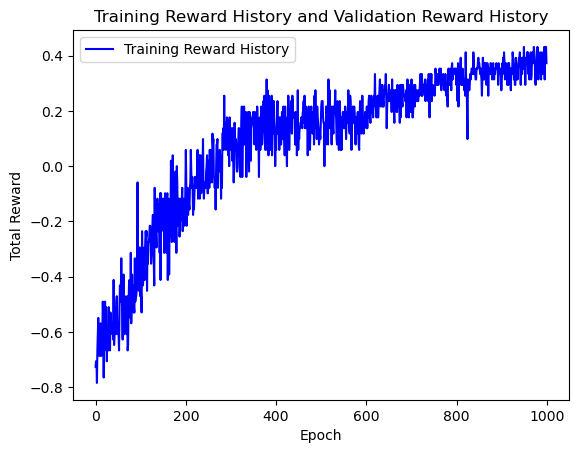

In [7]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
#plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

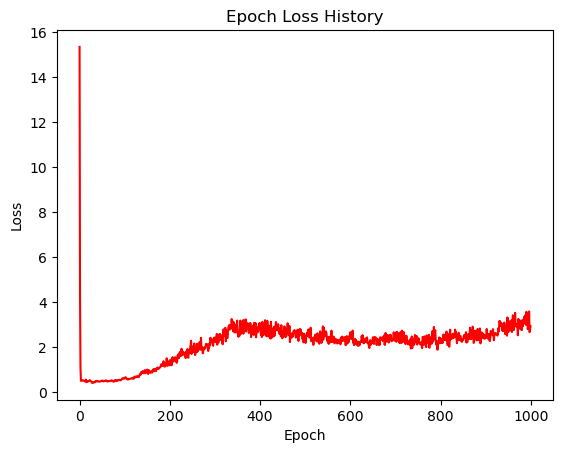

In [8]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [10]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=3, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_98062/4279495882.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net_trained.load_state_dict(torch.load

<All keys matched successfully>

In [11]:
tx_cost = 0.0

test_rewards,trade_profits,actions,episodes,metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_test,
    prices_test,
    beta_series_test,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
)
print(metrics)

{'avg_reward': -0.17266187050359713, 'win_rate': 0.41007194244604317, 'loss_rate': 0.2014388489208633, 'forced_rate': 0.007194244604316547, 'no_trade_rate': 0.381294964028777}


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  4.,  5.,
         5.,  7.,  3., 58.,  4., 16., 10.,  8.,  8.,  4.,  2.]),
 array([-356.00565771, -347.5621361 , -339.11861448, -330.67509286,
        -322.23157124, -313.78804962, -305.34452801, -296.90100639,
        -288.45748477, -280.01396315, -271.57044154, -263.12691992,
        -254.6833983 , -246.23987668, -237.79635507, -229.35283345,
        -220.90931183, -212.46579021, -204.02226859, -195.57874698,
        -187.13522536, -178.69170374, -170.24818212, -161.80466051,
        -153.36113889, -144.91761727, -136.47409565, -128.03057403,
        -119.58705242, -111.1435308 , -102.70000918,  -94.25648756,
         -85.81296595,  -77.36944433,  -68.92592271,  -60.48240109,
         -52.03887948,  -43.59535786,  -35.15183624,  -26.70831462,
         -18.264793  ,   -9.82127139

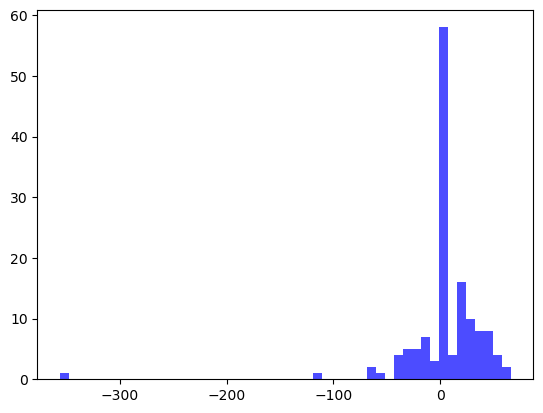

In [19]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)